# Advanced Lane Finding Project

In [1]:
# imports
import numpy as np
import cv2
import glob
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
# Helper functions for plotting images
def plot_single_image(image, cmap=None):
    fig = plt.figure(figsize=(12, 8))
    plt.imshow(image, cmap=cmap)

def plot_images_side_by_side(image1, image2, cmap1=None, cmap2=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image1, cmap=cmap1)
    ax1.set_title('Before', fontsize=40)

    ax2.imshow(image2, cmap=cmap2)
    ax2.set_title('After', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Camera Calibration

In [3]:
# Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
def get_cal_matrix_and_dist_coefs(images, nx=9, ny=6):
    # Arrays to hold object points and image points
    objpoints = []
    imgpoints = []
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    # Loop through images to find corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)   
        
        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        corner_ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, run camera calibration based on corners
        if corner_ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    
    # Calculate and return calibration matrix and distortion coefficients
    cal_ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

images = glob.glob('./camera_cal/calibration*.jpg')
mtx, dist = get_cal_matrix_and_dist_coefs(images)

In [4]:
# Apply a distortion correction to raw images.
def correct_images(images, mtx, dist):
    corrected_images = []
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        dst = cv2.undistort(img, mtx, dist, None, mtx)
        corrected_images.append(dst)

    return corrected_images

# Correct single image
def correct_image(image, mtx, dist):
    return cv2.undistort(image, mtx, dist, None, mtx)

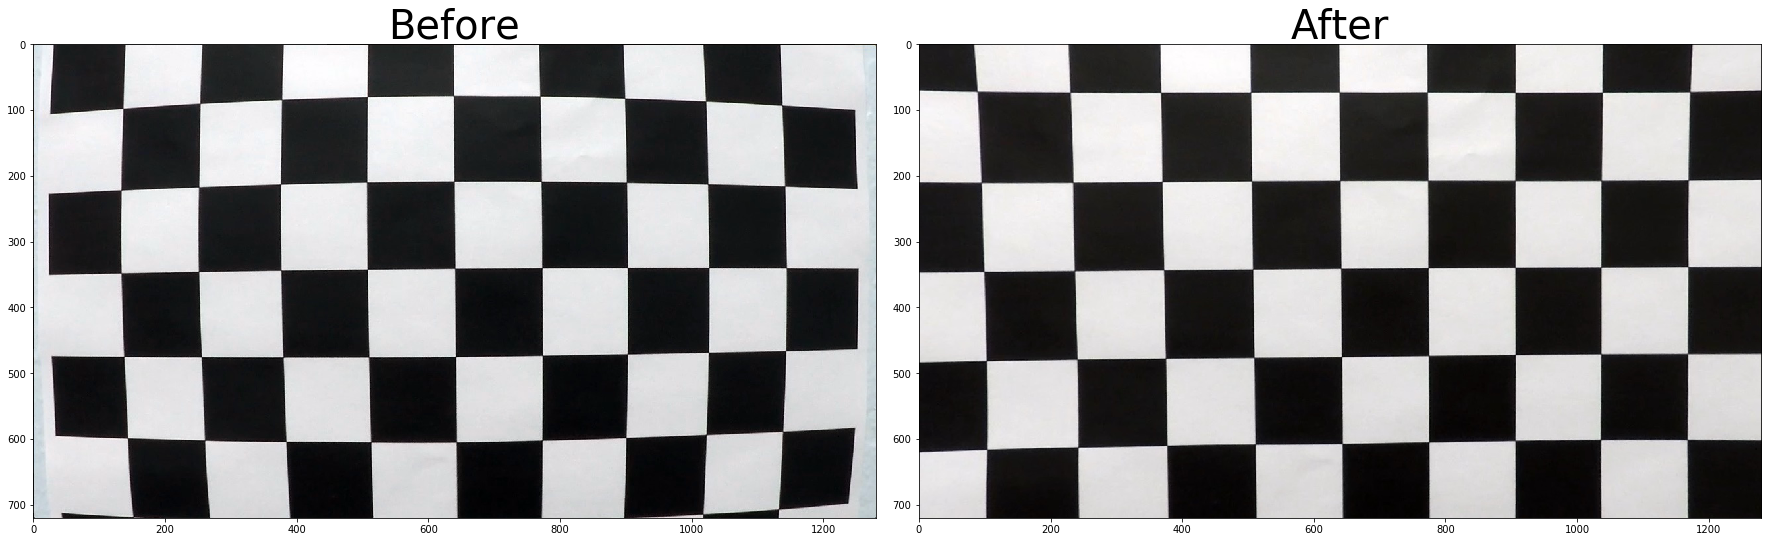

In [5]:
# Display distorted and undistorted images side by side
dist_img = cv2.imread(images[0])
undist_img = correct_images([images[0]], mtx, dist)[0]
plot_images_side_by_side(dist_img, undist_img, None, None)

## Pipeline (single images)

### Distortion-corrected image

In [6]:
# Get image paths and image names
images = glob.glob('./test_images/*.jpg')
image_names = [img_name.split('/')[-1].split('.')[0] for img_name in images]

# Undistort the test images of highway lanes and save in output_images folder
corrected_images = correct_images(images, mtx, dist)
for img, img_name in zip(corrected_images, image_names):
    cv2.imwrite('./output_images/{}_undistorted.jpg'.format(img_name), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

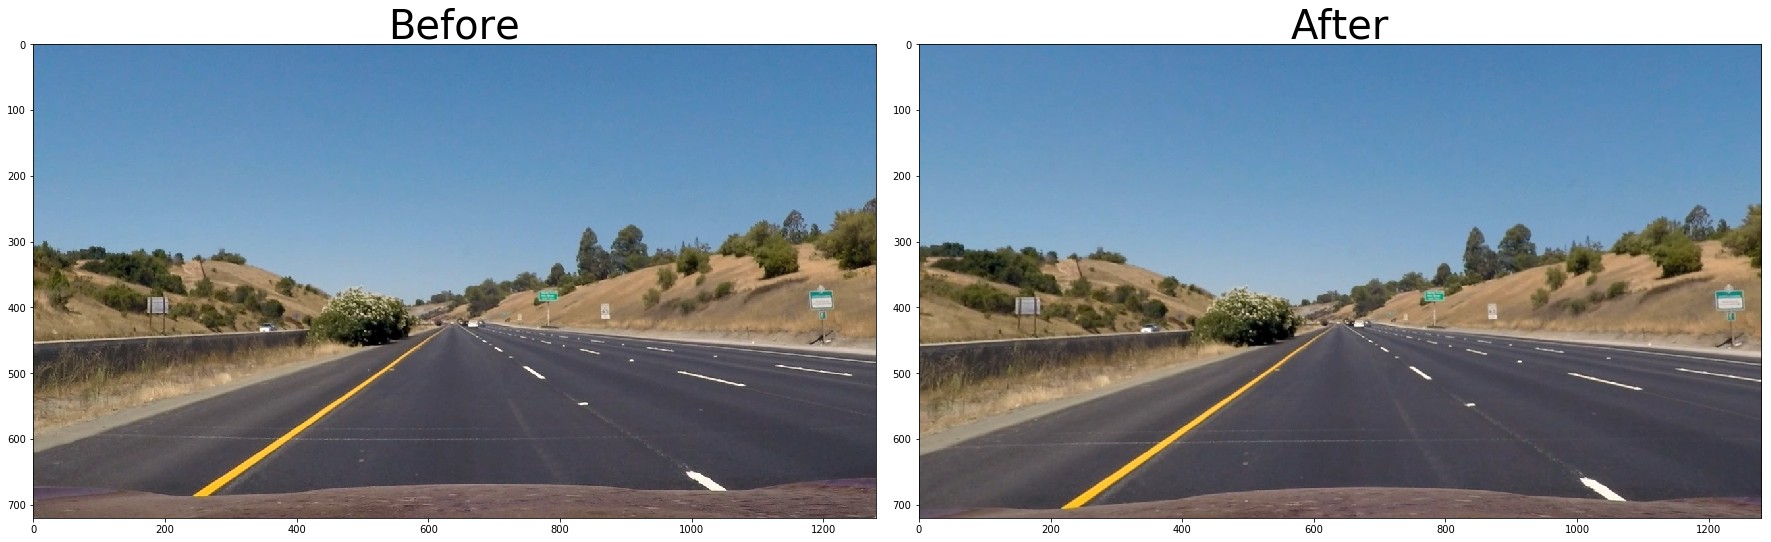

In [7]:
# Compare distort and undistorted
dist_img = cv2.cvtColor(cv2.imread(images[0]), cv2.COLOR_BGR2RGB)
plot_images_side_by_side(dist_img, corrected_images[0], None, None)

### Thresholded binary image

In [8]:
# Use color transforms, gradients, etc., to create a thresholded binary image.
def color_and_gradient_pipeline(img, s_thresh=(120, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Extract R, G, and B channels
    r_channel = img[:,:,0]
    g_channel = img[:,:,1]
    b_channel = img[:,:,2]
    
    # Find black pixels
    black = np.ones_like(r_channel)
    black[(r_channel <= 48) & (g_channel <= 48) & (b_channel <= 48)] = 0
    
    # Find white pixels
    white = np.zeros_like(r_channel)
    white[(r_channel >= 192) & (g_channel >= 192) & (b_channel >= 192)] = 1
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Subtract black pixels from saturation
    s_binary = np.logical_and(s_binary,black)
    
    # Add white pixels from saturation
    s_binary = np.logical_or(s_binary,white)

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    zeros = np.zeros_like(sxbinary)
    binary_or = np.logical_or(sxbinary,s_binary).astype(float)

    color_binary = np.dstack(( binary_or, binary_or, binary_or))
    return color_binary

In [9]:
binary_images = []
for img in corrected_images:
    binary_images.append(color_and_gradient_pipeline(img))

In [10]:
# Write binary images to output_images
for img, img_name in zip(binary_images, image_names):
    cv2.imwrite('./output_images/{}_binary.jpg'.format(img_name), img.astype(np.uint8) * 255)

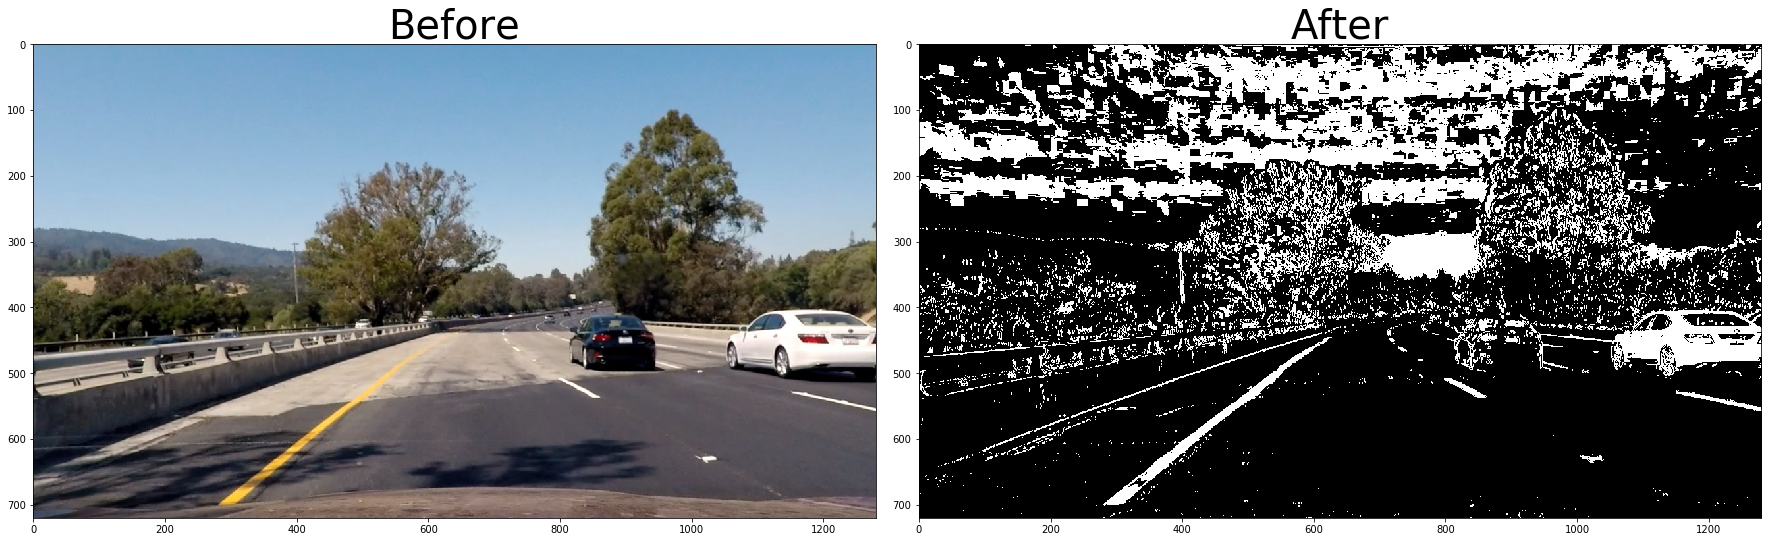

In [11]:
# Select an image index for comparison and output
img_index = 5
plot_images_side_by_side(corrected_images[img_index], binary_images[img_index], None, None)

### Perspective transform

In [12]:
# Hardcode source and destination points
h, w, offset = 720, 1280, 320
src = np.float32(np.array([[592,450], [686,450], [1114,720], [196,720]]).astype(int))
dst = np.float32([[offset, 0], [w-offset, 0], [w-offset, h], [offset, h]])

# Calculate a perspective transform to rectify images ("birds-eye view").
def calculate_perspective_transforms(src, dst):
    # Get M and Minv
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return M, Minv

def image_warper(image, M):
    # Warp the image using OpenCV warpPerspective()
    return cv2.warpPerspective(image, M, (1280,720))

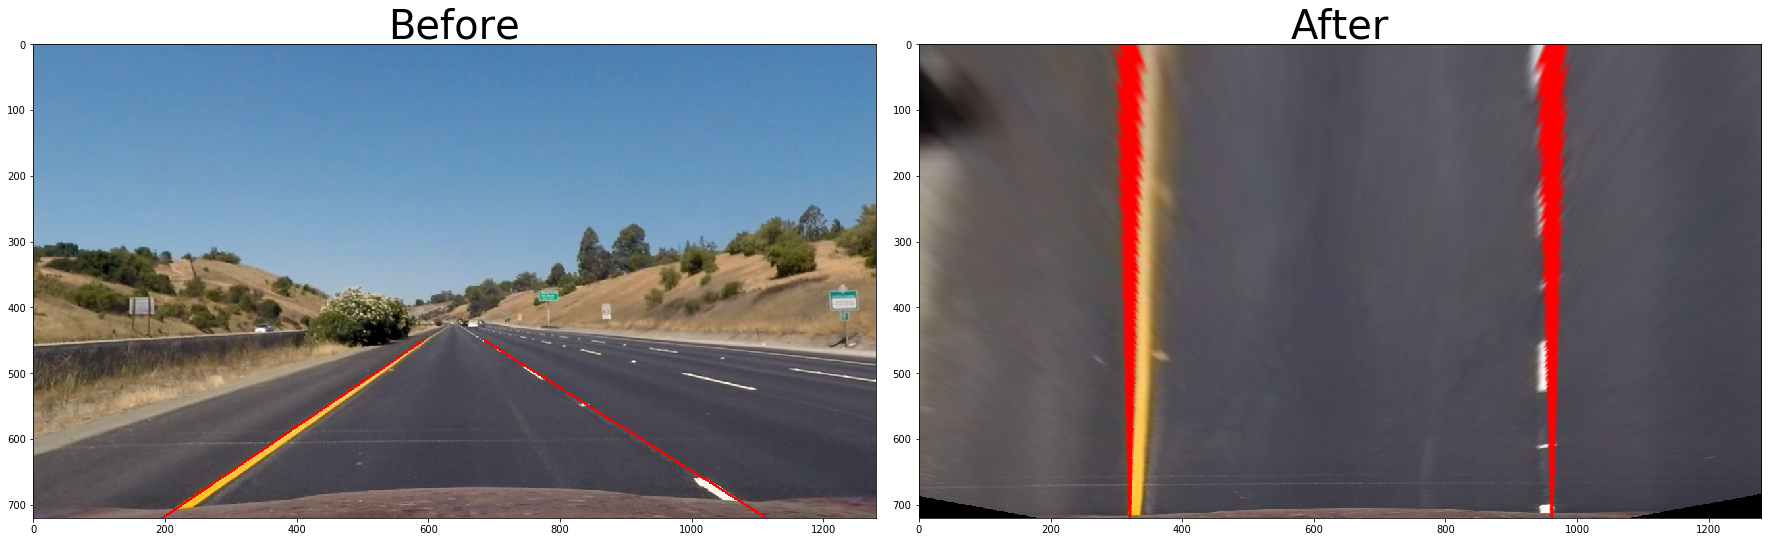

In [13]:
# Draw lines on straight line image
line_img = deepcopy(corrected_images[0])
color, thickness = ([255, 0, 0], 2)
#cv2.line(line_img, (bot_l[0], bot_l[1]), (top_l[0], top_l[1]), color, thickness)
#cv2.line(line_img, (bot_r[0], bot_r[1]), (top_r[0], top_r[1]), color, thickness)
cv2.line(line_img, (src[3][0], src[3][1]), (src[0][0], src[0][1]), color, thickness)
cv2.line(line_img, (src[2][0], src[2][1]), (src[1][0], src[1][1]), color, thickness)

# Calculate M and Minv values and get warped image
M, Minv = calculate_perspective_transforms(src, dst)
warped_img = image_warper(line_img, M)

# Plot images side by side
plot_images_side_by_side(line_img, warped_img)

# Write images to output_images
cv2.imwrite('./output_images/line_image.jpg'.format(img_name), cv2.cvtColor(line_img, cv2.COLOR_RGB2BGR))
cv2.imwrite('./output_images/warped_image.jpg'.format(img_name), cv2.cvtColor(warped_img, cv2.COLOR_RGB2BGR))
plt.savefig("./output_images/lines_with_warped_lines.png", transparent=True)

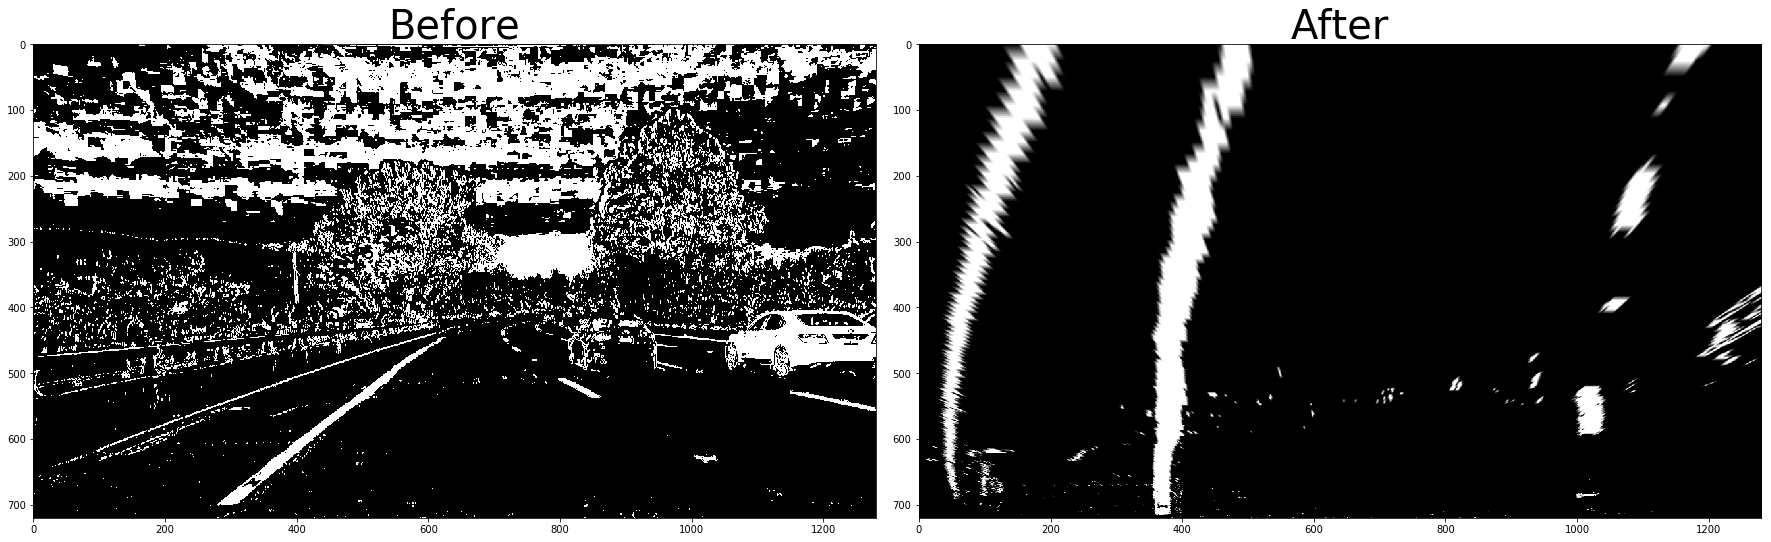

In [14]:
# Display warped image binary
warped_img = image_warper(binary_images[img_index], M)
cv2.imwrite('./output_images/test1_transformed.jpg', warped_img.astype(np.uint8) * 255)
plot_images_side_by_side(binary_images[img_index], warped_img, None, 'gray')

### Identifying lane-line pixels and fitting their positions with a polynomial &
### Calculate the radius of curvature of the lane and the position of the vehicle with respect to center

In [15]:
# Ensure binary warped image is truly binary, as pixel values can be scaled down after warping
def ensure_binary(image):
    image[image > 0] = 1
    image = image.astype(np.uint8) * 255
    return image

In [16]:
def find_and_paint_lane(orig_image, warped_img, left_fit, right_fit):
    # Take a histogram of the bottom half of the image
    binary_warped = warped_img[:,:,-1]
    histogram = np.sum(binary_warped[binary_warped.shape[0]//4*2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    lane_pixels = np.dstack((binary_warped, binary_warped, binary_warped))*0
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Number of sliding windows and window height
    nwindows = 9
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin and minimum number of pixels found to recenter window
    margin = 100
    minpix = 50
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    if left_fit == None or right_fit == None:
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    else:
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))

    try:

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Create red left lane and blue right lane lines
#         fig1 = plt.figure(figsize=(12, 9))
#         ax = fig1.add_subplot(111)
#         lane_pixels[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#         lane_pixels[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#         ax.plot(left_fitx, ploty, color='yellow')
#         ax.plot(right_fitx, ploty, color='yellow')
#         ax.set_xlim(0, 1280)
#         ax.set_ylim(720, 0)
#         implot = ax.imshow(lane_pixels)
#         fig1.savefig('./output_images/lane_pixels.png', transparent=True)
#         plt.figure()

        # Find curve in radians
        y_eval = np.max(ploty)
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
        radius_text = "Radius of Curvature = {}(m)".format(int(left_curverad))
        
        # Find distance from center of lane
        lane_midpoint = ((right_fitx[-1] - left_fitx[-1]) / 2) + left_fitx[-1]
        offset = lane_midpoint - midpoint
        offset_in_m = offset * xm_per_pix
        if offset_in_m >= 0:
            center_text = "Vehicle is {0:.2f}m left of center".format(round(offset_in_m,2))
        else:
            center_text = "Vehicle is {0:.2f}m right of center".format(round(abs(offset_in_m),2))

        # Warp the detected lane boundaries back onto the original image.
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw lane lines
        #left_lane_line = nonzeroy[left_lane_inds], nonzerox[left_lane_inds]
        lanes_line_img = np.dstack((binary_warped, binary_warped, binary_warped))*0
        cv2.polylines(lanes_line_img, np.int_([pts_left]), False, (255,0,0), thickness=12, lineType=cv2.LINE_AA)
        cv2.polylines(lanes_line_img, np.int_([pts_right]), False, (0,0,255), thickness=12, lineType=cv2.LINE_AA)
        #plt.imshow(lanes_line_img)
        
        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (1280,720)) 
        lines_warp = cv2.warpPerspective(lanes_line_img, Minv, (1280,720)) 
        # Combine the result with the original image
        result = cv2.addWeighted(orig_image, 1, newwarp, 0.3, 0)
        result = cv2.addWeighted(result, 1, lines_warp, 1, 0)

        # Add text to output image
        result = cv2.putText(result, radius_text, (50, 60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
        result = cv2.putText(result, center_text, (50, 120), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2, cv2.LINE_AA)
    except:
        # Red image if no lines found
        raise
        warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
        red_image = np.dstack((warp_zero, warp_zero, warp_zero))
        red_image[:,:,0] = 255
        result = cv2.addWeighted(orig_image, 1, red_image, 1.0, 0)
    return result, left_fit, right_fit

### Result image

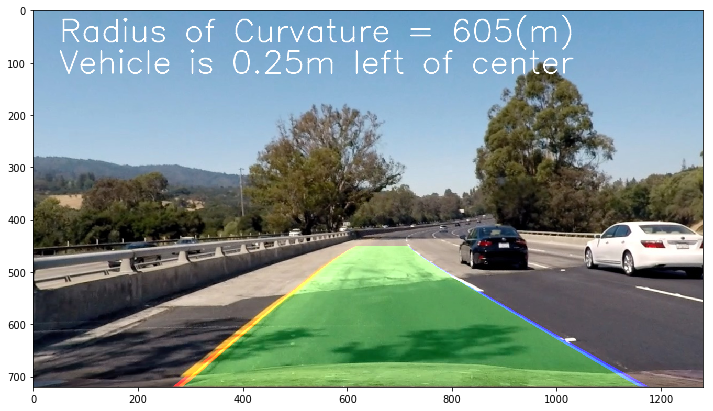

In [17]:
# Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
orig_img = deepcopy(corrected_images[5])
image = color_and_gradient_pipeline(deepcopy(orig_img))
warped_img = image_warper(image, M)
warped_img = ensure_binary(warped_img)
output, _, _ = find_and_paint_lane(orig_img, warped_img, None, None)
cv2.imwrite('./output_images/result_image.jpg', cv2.cvtColor(output, cv2.COLOR_RGB2BGR))
plot_single_image(output)
#plt.savefig("./output_images/result_image.png", transparent=True)

In [18]:
left_fit, right_fit = None, None
def image_processing_pipeline(image):
    global left_fit
    global right_fit
    
    # 0. Create copy of original image
    orig_image = deepcopy(image)
    
    # 1. Correct image distortion
    image = correct_image(image, mtx, dist)
    
    # 2. Color and gradient filtering
    image = color_and_gradient_pipeline(image)
      
    # 3. Warp image (for bird's eye view)
    image = image_warper(image, M)
    
    # 4. Ensure binary image after warping
    image = ensure_binary(image)
    
    # 5. Find and paint lane
    image, left_fit, right_fit = find_and_paint_lane(orig_image, image, left_fit, right_fit)

    return image

In [19]:
# debug = 0
# left_fit, right_fit = None, None
# def debug_image_processing_pipeline(image):
#     # 0. Create copy of original image
#     orig_image = deepcopy(image)
#     global debug
#     global left_fit
#     global right_fit
#     debug += 1
    
#     # 1. Correct image distortion
#     image = correct_image(image, mtx, dist)
#     cv2.imwrite('./debug_output/01_{}.jpg'.format(debug), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    
#     # 2. Color and gradient filtering
#     image = color_and_gradient_pipeline(image).astype(np.uint8) * 255
#     cv2.imwrite('./debug_output/02_{}.jpg'.format(debug), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
      
#     # 3. Warp image (for bird's eye view)
#     image = image_warper(image, M)
#     cv2.imwrite('./debug_output/03_{}.jpg'.format(debug), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    
#     # 4. Ensure binary image after warping
#     image = ensure_binary(image)
#     cv2.imwrite('./debug_output/04_{}.jpg'.format(debug), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    
#     # 5. Find and paint lane
#     image, left_fit, right_fit = find_and_paint_lane(orig_image, image, left_fit, right_fit)
#     cv2.imwrite('./debug_output/05_{}.jpg'.format(debug), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

#     return image

In [20]:
# fname = './test_images/straight_lines2.jpg'
# img = cv2.imread(fname)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# #plt.imshow(correct_image(img, mtx, dist))
# z = image_processing_pipeline(img)
# plt.imshow(z)

In [21]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [22]:
def process_image(image):
    # you should return the final output (image where lines are drawn on lanes)
    result = image_processing_pipeline(image)
    return result

In [23]:
video_output = './output_images/project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("./project_video.mp4").subclip(38,43)
clip1 = VideoFileClip("./project_video.mp4")
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video ./output_images/project_video_output.mp4
[MoviePy] Writing video ./output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [06:12<00:00,  3.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_video_output.mp4 

CPU times: user 6min 19s, sys: 1min 28s, total: 7min 48s
Wall time: 6min 13s


### Extra

In [24]:
# video_output = './output_images/challenge_video_output.mp4'
# ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# ## To do so add .subclip(start_second,end_second) to the end of the line below
# ## Where start_second and end_second are integer values representing the start and end of the subclip
# ## You may also uncomment the following line for a subclip of the first 5 seconds
# #clip1 = VideoFileClip("./challenge_video.mp4").subclip(38,43)
# clip1 = VideoFileClip("./challenge_video.mp4")
# video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# %time video_clip.write_videofile(video_output, audio=False)

In [25]:
# video_output = './output_images/harder_challenge_video_output.mp4'
# ## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
# ## To do so add .subclip(start_second,end_second) to the end of the line below
# ## Where start_second and end_second are integer values representing the start and end of the subclip
# ## You may also uncomment the following line for a subclip of the first 5 seconds
# #clip1 = VideoFileClip("./challenge_video.mp4").subclip(38,43)
# clip1 = VideoFileClip("./harder_challenge_video.mp4")
# video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# %time video_clip.write_videofile(video_output, audio=False)